<a href="https://colab.research.google.com/github/Eliane-M/data_preprocessing/blob/main/transitive_properties_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Task Two




In [2]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
transactions_df = pd.read_csv("../augmented_dataset/customer_transactions_augmented.csv")
social_profiles_df = pd.read_csv("../initial_dataset/customer_social_profiles.csv")
id_mapping_df = pd.read_csv("../initial_dataset/id_mapping.csv")

In [3]:
# See the colums in the transactions_df
transactions_df.columns

Index(['customer_id_legacy', 'transaction_id', 'purchase_amount',
       'purchase_date', 'product_category', 'customer_rating'],
      dtype='object')

In [4]:
# See the colums in the social_profiles_df
social_profiles_df.columns

Index(['customer_id_new', 'social_media_platform', 'engagement_score',
       'purchase_interest_score', 'review_sentiment'],
      dtype='object')

In [5]:
# See the colums in the id_mapping_df
id_mapping_df.columns

Index(['customer_id_legacy', 'customer_id_new'], dtype='object')

In [6]:
id_mapping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id_legacy  155 non-null    int64 
 1   customer_id_new     155 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.6+ KB


#### Point 2  Perform a Complex Merge

In [7]:
# Step 2: Clean ID Mapping
id_mapping_df = id_mapping_df.drop_duplicates(subset=['customer_id_legacy'], keep='first')

In [8]:
# 1: Merge transactions with ID mapping
merged_df = transactions_df.merge(id_mapping_df, on="customer_id_legacy", how="left")

# 2: Merge with social media profiles
final_df = merged_df.merge(social_profiles_df, on="customer_id_new", how="left")

# Handle missing social profiles (customers without social media data)
final_df.fillna({
    "social_media_platform": "Unknown",
    "engagement_score": final_df["engagement_score"].median(),
    "purchase_interest_score": final_df["purchase_interest_score"].median(),
    "review_sentiment": "Neutral"
}, inplace=True)

In [9]:
final_df.head(10)

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,151,1001,5.955135,2024-01-01,Sports,2.3,A176,Facebook,70.0,3.3,Negative
1,192,1002,5.770549,2024-01-02,Electronics,4.2,A156,Instagram,52.0,4.9,Positive
2,114,1003,6.088135,2024-01-03,Electronics,2.1,A171,Unknown,78.0,3.6,Neutral
3,171,1004,5.692522,2024-01-04,Clothing,2.8,NaN,Unknown,78.0,3.6,Neutral
4,160,1005,4.162725,2024-01-05,Clothing,1.3,NaN,Unknown,78.0,3.6,Neutral
5,120,1006,5.892572,2024-01-06,Groceries,1.1,A159,Unknown,78.0,3.6,Neutral
6,182,1007,4.558162,2024-01-07,Sports,4.9,A193,TikTok,69.0,2.6,Negative
7,186,1008,6.019805,2024-01-08,Clothing,4.3,A160,TikTok,56.0,2.6,Positive
8,186,1008,6.019805,2024-01-08,Clothing,4.3,A160,LinkedIn,73.0,2.0,Neutral
9,186,1008,6.019805,2024-01-08,Clothing,4.3,A160,Instagram,89.0,2.9,Neutral


In [10]:
print(final_df.isnull().sum())

customer_id_legacy          0
transaction_id              0
purchase_amount             0
purchase_date               0
product_category            0
customer_rating             0
customer_id_new            62
social_media_platform       0
engagement_score            0
purchase_interest_score     0
review_sentiment            0
dtype: int64


In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id_legacy       466 non-null    int64  
 1   transaction_id           466 non-null    object 
 2   purchase_amount          466 non-null    float64
 3   purchase_date            466 non-null    object 
 4   product_category         466 non-null    object 
 5   customer_rating          466 non-null    float64
 6   customer_id_new          404 non-null    object 
 7   social_media_platform    466 non-null    object 
 8   engagement_score         466 non-null    float64
 9   purchase_interest_score  466 non-null    float64
 10  review_sentiment         466 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 40.2+ KB


### Point 3: Feature Engineering & Transformation

In [12]:
# Compute Customer Engagement Score
final_df["customer_engagement_score"] = (
    0.6 * final_df["engagement_score"] + 0.4 * final_df["purchase_interest_score"]
)

# Convert purchase_date to datetime
final_df["purchase_date"] = pd.to_datetime(final_df["purchase_date"])

# Compute Moving Average of Last 3 Transactions
final_df["moving_avg_purchase"] = final_df.groupby("customer_id_legacy")["purchase_amount"].transform(lambda x: x.rolling(3, min_periods=1).mean())

# Aggregate Monthly Spending
final_df["purchase_month"] = final_df["purchase_date"].dt.to_period("M")
monthly_spending = final_df.groupby(["customer_id_legacy", "purchase_month"])["purchase_amount"].agg(["sum", "mean"]).reset_index()
monthly_spending.rename(columns={"sum": "monthly_total_spend", "mean": "monthly_avg_spend"}, inplace=True)

# Merge Monthly Spending Data
final_df = final_df.merge(monthly_spending, on=["customer_id_legacy", "purchase_month"], how="left")

In [13]:
final_df = pd.get_dummies(final_df, columns=['product_category'])

In [14]:
vectorizer = TfidfVectorizer(max_features=10)
tfidf_matrix = vectorizer.fit_transform(final_df['review_sentiment'].fillna(''))

In [15]:
print(final_df.duplicated().sum())  # Count duplicate rows
print(final_df.isnull().sum())
final_df.info()  # Count missing values

2
customer_id_legacy               0
transaction_id                   0
purchase_amount                  0
purchase_date                    0
customer_rating                  0
customer_id_new                 62
social_media_platform            0
engagement_score                 0
purchase_interest_score          0
review_sentiment                 0
customer_engagement_score        0
moving_avg_purchase              0
purchase_month                   0
monthly_total_spend              0
monthly_avg_spend                0
product_category_Books           0
product_category_Clothing        0
product_category_Electronics     0
product_category_Groceries       0
product_category_Sports          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customer_id_legacy            466 non-null 

In [16]:
# Replace 'moving_avg_purchase' with the actual column if different
final_df = final_df.drop_duplicates()
final_df['avg_spent_last_3'] = final_df['moving_avg_purchase']  # Create the column
final_df['avg_spent_last_3'] = final_df['avg_spent_last_3'].fillna(final_df['avg_spent_last_3'].median())

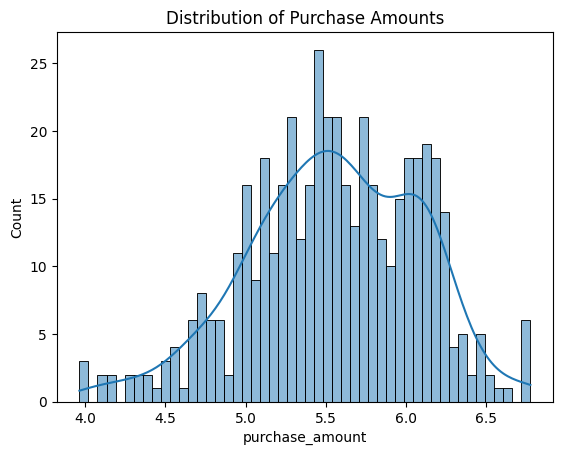

In [17]:
sns.histplot(final_df['purchase_amount'], bins=50, kde=True)
plt.title("Distribution of Purchase Amounts")
plt.show()

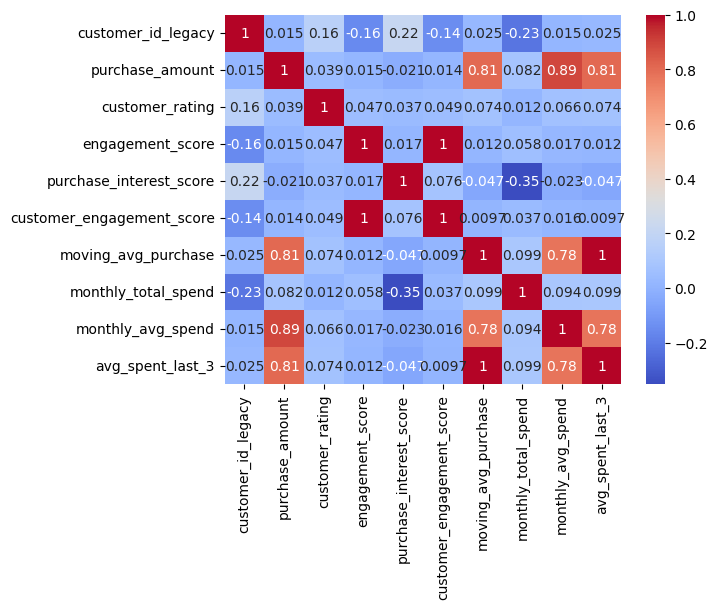

In [18]:
# Select only numeric columns for correlation
df_numeric = final_df.select_dtypes(include=[np.number])

# Calculate correlation matrix
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [20]:
final_df.to_csv("final_customer_data_10.csv", index=False)